In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics

%load_ext lab_black

In [3]:
dtype_dict = {
    "bathrooms": float,
    "waterfront": int,
    "sqft_above": int,
    "sqft_living15": float,
    "grade": int,
    "yr_renovated": int,
    "price": float,
    "bedrooms": float,
    "zipcode": str,
    "long": float,
    "sqft_lot15": float,
    "sqft_living": float,
    "floors": str,
    "condition": int,
    "lat": float,
    "date": str,
    "sqft_basement": int,
    "yr_built": int,
    "id": str,
    "sqft_lot": int,
    "view": int,
}

In [4]:
test = pd.read_csv(
    "housing-data_polynomial/wk3_kc_house_test_data.csv", dtype=dtype_dict
)
train = pd.read_csv(
    "housing-data_polynomial/wk3_kc_house_test_data.csv", dtype=dtype_dict
)
valid = pd.read_csv(
    "housing-data_polynomial/wk3_kc_house_test_data.csv", dtype=dtype_dict
)

In [90]:
def createDfSets():
    sets = []
    for i in range(1, 5):
        path = "housing-data_polynomial/wk3_kc_house_set_" + str(i) + "_data.csv"
        df = pd.read_csv(path, dtype=dtype_dict)
        sets.append(df)
    return sets


sets = createDfSets()

In [310]:
# build a polynomial model
feature = "sqft_living"
target = "price"
l2_small_penalty = 1.5e-5


def process(data, features):

    partial = data[[f for f in features] + [target]].sort_values(by=features)
    x_reshape = (
        partial[features].values.reshape(-1, 1)
        if len(features) == 1
        else partial[features]
    )
    y = partial[target]

    return (x_reshape, y)


def ridgeModel(degree, alpha):
    train_x_reshape, train_y = process(train)
    poly = PolynomialFeatures(degree)
    poly.fit_transform(train_x_reshape)

    model = Pipeline([("poly", poly), ("ridge", Ridge(alpha, normalize=True))])
    model.fit(train_x_reshape, train_y)

    pred = model.predict(train_x_reshape)
    coef = model.named_steps["ridge"].coef_

    return dict(zip(("model", "pred", "coef"), (model, pred, coef)))

In [17]:
# degree 15, small l2 penalty
model_15sm = ridgeModel(15, l2_small_penalty)

In [18]:
model_15sm["coef"]

array([ 0.00000000e+00,  3.13970178e+02, -1.01296366e-01,  1.32626175e-05,
        3.68212296e-09,  5.09182513e-14, -5.26139454e-17, -7.51592812e-21,
       -4.61991715e-25,  7.59572278e-30,  4.98835610e-33,  5.87223001e-37,
        3.60531258e-41,  9.01340905e-46,  2.88728088e-49,  1.70766518e-52])

In [19]:
l2_small_penalty = 1e-9


def ridgeModelSet(data_set, degree, alpha):
    x_reshape, y = process(data_set)

    poly = PolynomialFeatures(degree)
    poly.fit_transform(x_reshape)

    model = Pipeline([("poly", poly), ("ridge", Ridge(alpha, normalize=True))])
    model.fit(x_reshape, y)

    pred = model.predict(x_reshape)
    coef = model.named_steps["ridge"].coef_
    mse = metrics.mean_squared_error(y, pred)

    return dict(zip(("model", "pred", "coef", "mse"), (model, pred, coef, mse)))

In [94]:
models_sm = [ridgeModelSet(sets[i], 15, l2_small_penalty) for i in range(4)]

In [72]:
def polyFunc(model):
    coef = np.append(
        model.named_steps["ridge"].coef_[-1:0:-1],
        model.named_steps["ridge"].intercept_,
    )
    poly = np.poly1d(coef)
    return poly


"""
plot training data and predicted function as a line
"""


def plotResults(data_set, model, ax):
    x_reshape, y = process(data_set)

    # true data
    ax.scatter(x_reshape, y, c="orange")
    # predicted regression line
    poly = polyFunc(model)
    ax.plot(x_reshape, poly(x_reshape))

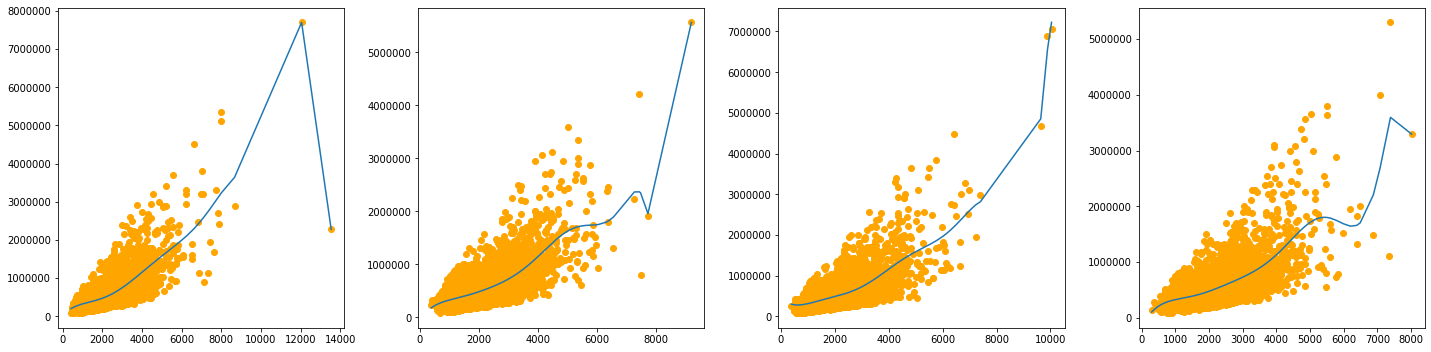

In [95]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 5))
for i in range(4):
    plotResults(sets[i], models_sm[i]["model"], axes[i])

plt.tight_layout()

In [77]:
[m["coef"][1] for m in models]

[544.6694079091435, 859.3626594796898, -755.395908963675, 1119.4456687499899]

# Ridge Regression

In [96]:
l2_large_penalty = 1.23e2
models_lg = [ridgeModelSet(sets[i], 15, l2_large_penalty) for i in range(4)]

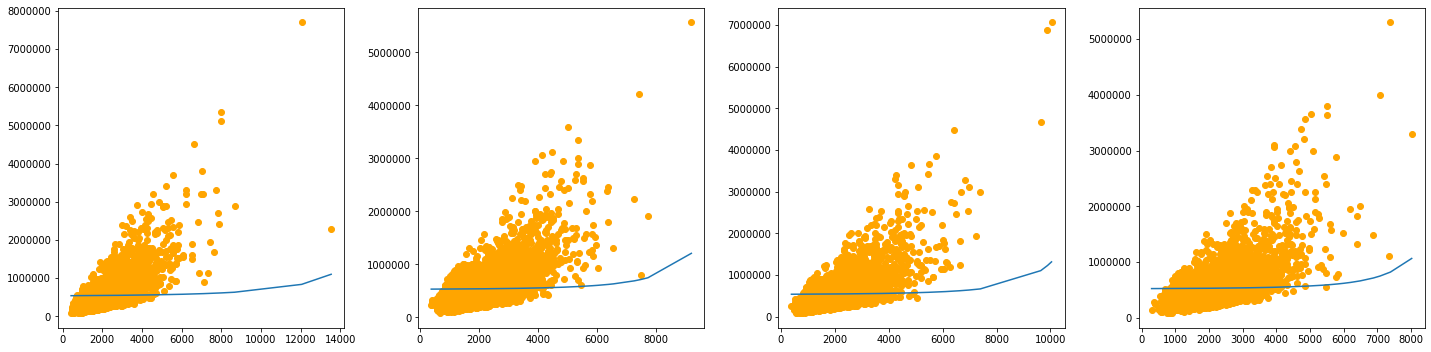

In [97]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 5))
for i in range(4):
    plotResults(sets[i], models_lg[i]["model"], axes[i])

plt.tight_layout()

In [98]:
[m["coef"][1] for m in models_lg]

[2.3280680295793235, 2.097569027778553, 2.289062581189204, 2.085961940919308]

# Implementing Cross Validation by using KFold

In [135]:
from sklearn.model_selection import KFold

tv_shuf = pd.read_csv(
    "housing-data_polynomial/wk3_kc_house_train_valid_shuffled.csv", dtype=dtype_dict
)
degree = 15
l2_penalty = np.logspace(3, 9, num=13)

n_folds = 10
cv = KFold(n_splits=n_folds)
ind = [(train, test) for train, test in cv.split(tv_shuf)]

In [226]:
def ridgeModelCV(degree, alpha, train_x_reshape, train_y):

    poly = PolynomialFeatures(degree)
    poly.fit_transform(train_x_reshape)

    model = Pipeline([("poly", poly), ("ridge", Ridge(alpha, normalize=True))])
    model.fit(train_x_reshape, train_y)

    return model


errors = []
for i in range(10):
    train_set = tv_shuf.loc[ind[i][0]]
    test_set = tv_shuf.loc[ind[i][1]]
    train_x_reshape, train_y = process(train_set)
    test_x_reshape, test_y = process(test_set)
    for l in l2_penalty:
        cvm = ridgeModelCV(degree, l, train_x_reshape, train_y)
        pred_y = cvm.predict(test_x_reshape)
        errors.append(metrics.mean_squared_error(test_y, pred_y))

In [228]:
# print errors into DataFrame and apply styling

cols = []
colsname = []
step = 13
for i in range(0, len(errors), step):
    cols.append(errors[i : i + step])
    colsname.append("k-" + str(i // step))
errorsDf = pd.DataFrame(data=dict(zip(colsname, cols)))

def color_min_red(col):
    col = errorsDf["k-9"]
    colors = ["color: red" if c == col.min() else "color: black" for c in col]
    return colors

errorsDf.style.apply(color_min_red).format("{:e}")

,k-0,k-1,k-2,k-3,k-4,k-5,k-6,k-7,k-8,k-9
0,1.275459e+11,1.305850e+11,1.102654e+11,1.330195e+11,1.261697e+11,1.498250e+11,1.630728e+11,1.478889e+11,1.169471e+11,1.608480e+11
1,1.278351e+11,1.308660e+11,1.105434e+11,1.332805e+11,1.264458e+11,1.507025e+11,1.634616e+11,1.481903e+11,1.171895e+11,1.613419e+11
2,1.279271e+11,1.309554e+11,1.106318e+11,1.333634e+11,1.265335e+11,1.510011e+11,1.635853e+11,1.482862e+11,1.172665e+11,1.614994e+11
3,1.279563e+11,1.309837e+11,1.106598e+11,1.333897e+11,1.265613e+11,1.510977e+11,1.636245e+11,1.483165e+11,1.172909e+11,1.615493e+11
4,1.279655e+11,1.309926e+11,1.106687e+11,1.333980e+11,1.265701e+11,1.511284e+11,1.636369e+11,1.483261e+11,1.172986e+11,1.615651e+11
5,1.279684e+11,1.309955e+11,1.106715e+11,1.334006e+11,1.265729e+11,1.511382e+11,1.636409e+11,1.483292e+11,1.173011e+11,1.615701e+11
6,1.279694e+11,1.309964e+11,1.106724e+11,1.334015e+11,1.265738e+11,1.511413e+11,1.636421e+11,1.483301e+11,1.173018e+11,1.615717e+11
7,1.279697e+11,1.309966e+11,1.106726e+11,1.334017e+11,1.265741e+11,1.511423e+11,1.636425e+11,1.483304e+11,1.173021e+11,1.615722e+11
8,1.279698e+11,1.309967e+11,1.106727e+11,1.334018e+11,1.265742e+11,1.511426e+11,1.636426e+11,1.483305e+11,1.173022e+11,1.615724e+11
9,1.279698e+11,1.309968e+11,1.106728e+11,1.334018e+11,1.265742e+11,1.511427e+11,1.636427e+11,1.483305e+11,1.173022e+11,1.615724e+11


# Implementing Ridge Reg using Gradient Descent

In [262]:
train = pd.read_csv("kc_house_train_data.csv", dtype=dtype_dict)
test = pd.read_csv("kc_house_test_data.csv", dtype=dtype_dict)
train_x_reshape, train_y = process(train)
test_x_reshape, test_y = process(test)

In [277]:
l2_small_penalty = 0.0
model_gd = Ridge(alpha=l2_start_penalty, normalize=True, max_iter=1000, solver="saga")
model_gd.fit(train_x_reshape, train_y)

Ridge(alpha=0.0, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      random_state=None, solver='saga', tol=0.001)

In [265]:
simple_weights_0_penalty = model_gd.coef_

In [266]:
simple_weights_0_penalty

array([281.08524738])

In [267]:
l2_high_penalty = 1e11

In [269]:
model_gd2 = Ridge(alpha=l2_high_penalty, normalize=True, max_iter=1000, solver="saga")
model_gd2.fit(train_x_reshape, train_y)

Ridge(alpha=100000000000.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=True, random_state=None, solver='saga', tol=0.001)

In [270]:
simple_weights_high_penalty = model_gd2.coef_
simple_weights_high_penalty

array([2.82405145e-09])

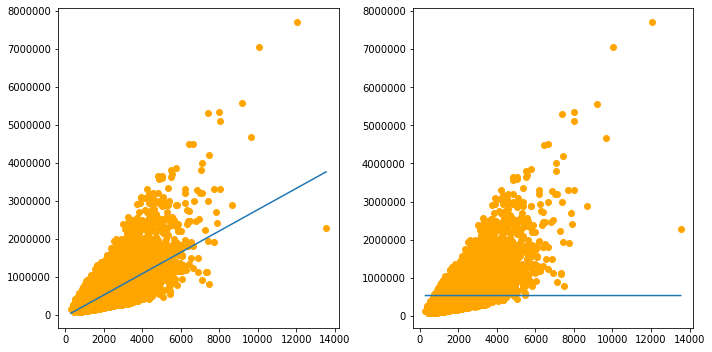

In [273]:
def plotResults(data_set, model, ax):
    x_reshape, y = process(data_set)

    # true data
    ax.scatter(x_reshape, y, c="orange")
    # predicted regression line
    poly = np.poly1d([model.coef_, model.intercept_])
    ax.plot(x_reshape, poly(x_reshape))


fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
plotResults(train, model_gd, axes[0])
plotResults(train, model_gd2, axes[1])
plt.tight_layout()
plt.show()

In [292]:
features = ["sqft_living", "sqft_living15"]

In [317]:
train_x_reshape, train_y = process(train, features)
model_gd3 = Ridge(alpha=l2_small_penalty, normalize=True, solver="saga", max_iter=1000)
model_gd3.fit(train_x_reshape, train_y)

Ridge(alpha=1.5e-05, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=True, random_state=None, solver='saga', tol=0.001)

In [318]:
multiple_weights_0_penalty = model_gd3.coef_
multiple_weights_0_penalty

array([245.21388856,  65.21124016])

In [314]:
model_gd4 = Ridge(alpha=l2_large_penalty, normalize=True, solver="saga", max_iter=1000)
model_gd4.fit(train_x_reshape, train_y)

Ridge(alpha=123.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=True, random_state=None, solver='saga', tol=0.001)

In [319]:
multiple_weights_high_penalty = model_gd4.coef_
multiple_weights_high_penalty

array([2.26164064, 2.51523317])

### Regularization
high regularization => lower coefs, more bias but less variance